# CNN model using k-mer embeddings learned from human genome
- Train Dataset = Worm
- Test Dataset = Worm


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from Bio.SeqIO.FastaIO import SimpleFastaParser
from sklearn.utils import resample
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize, MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier


In [3]:
input_hot_human = '../data/hot_lot_seqs/human/hot_regions_01_all.fa'
input_lot_human = '../data/hot_lot_seqs/human/lot_regions_01_all.fa'
input_hot_worm = '../data/hot_lot_seqs/worm/hot_region_01_all.fa'
input_lot_worm = '../data/hot_lot_seqs/worm/lot_region_01_all.fa'
kmer_length = 4
sampling_percentage = 1
seed = 35

In [4]:
with open(input_hot_human) as fasta_file:
    hot_sequences_human = []
    for title, sequence in SimpleFastaParser(fasta_file):
        if "N" not in sequence:
            hot_sequences_human.append(sequence)

with open(input_lot_human) as fasta_file:
    lot_sequences_human = []
    for title, sequence in SimpleFastaParser(fasta_file):
        if "N" not in sequence:
            lot_sequences_human.append(sequence)

with open(input_hot_worm) as fasta_file:
    hot_sequences_worm = []
    for title, sequence in SimpleFastaParser(fasta_file):
        if "N" not in sequence:
            hot_sequences_worm.append(sequence)

with open(input_lot_worm) as fasta_file:
    lot_sequences_worm = []
    for title, sequence in SimpleFastaParser(fasta_file):
        if "N" not in sequence:
            lot_sequences_worm.append(sequence)

### Create dataset for human and worm with two class label
The following cell creates dataframes for the HOT and LOT sequences with the following labels:
- *1* for HOT sequences (positive class)
- *0* for LOT sequences (negative class)

In [5]:
df_hot = pd.DataFrame(hot_sequences_human, columns=['sequence'])
df_hot['label'] = 1

df_lot = pd.DataFrame(lot_sequences_human, columns=['sequence'])
df_lot['label'] = 0

human_data = pd.concat([df_hot, df_lot])
human_data.label.value_counts()

1    1504
0    1495
Name: label, dtype: int64

In [6]:
df_hot = pd.DataFrame(hot_sequences_worm, columns=['sequence'])
df_hot['label'] = 1

df_lot = pd.DataFrame(lot_sequences_worm, columns=['sequence'])
df_lot['label'] = 0

worm_data = pd.concat([df_hot, df_lot])
worm_data.label.value_counts()

1    20139
0    18792
Name: label, dtype: int64

In [7]:
def seq2kmer_dataset(data, k, scaled= True):
    k = 4
    seq_kmers = []
    for df in range(len(data)):
        seq = data.iloc[df]['sequence']
        kmers = [seq[i:i+k].upper() for i in range(len(seq)-k+1)]
        kmers = ' '.join(kmers)
        seq_kmers.append(kmers)

    labels = data.loc[:,:]['label'].values

    c = CountVectorizer(ngram_range=(1,1))
    x = c.fit_transform(seq_kmers)
    scaler = MaxAbsScaler()
    x_scaled = scaler.fit_transform(normalize(x))
    df_kmer = pd.DataFrame(x.toarray(), columns=c.vocabulary_)
    df_kmer = df_kmer.reindex(sorted(df_kmer.columns), axis=1)

    df_kmer_scaled = pd.DataFrame(x_scaled.toarray(), columns=c.vocabulary_)
    df_kmer_scaled = df_kmer_scaled.reindex(sorted(df_kmer_scaled.columns), axis=1)

    if scaled:
        return df_kmer_scaled, labels
    else:
        return df_kmer, labels


In [8]:
X, y = seq2kmer_dataset(worm_data, 4, scaled=False)

In [9]:
X

,aaaa,aaac,aaag,aaat,aaca,aacc,aacg,aact,aaga,aagc,...,ttcg,ttct,ttga,ttgc,ttgg,ttgt,ttta,tttc,tttg,tttt
0,3,3,2,3,1,6,0,2,4,6,...,9,4,2,2,3,1,2,41,2,2
1,0,2,5,1,0,1,2,0,3,0,...,15,0,0,2,1,2,2,24,3,3
2,2,0,3,0,2,3,1,1,2,1,...,5,1,2,0,1,1,0,20,2,2
3,3,4,1,1,2,12,4,2,8,2,...,3,2,5,1,2,3,3,13,4,7
4,2,0,1,1,4,1,2,1,5,1,...,5,3,0,1,1,3,0,21,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38926,0,1,3,0,0,0,0,0,4,1,...,2,0,2,0,1,1,1,20,1,1
38927,5,3,9,2,3,1,1,5,3,4,...,7,2,2,1,6,2,0,20,1,6
38928,0,2,8,1,1,1,4,3,4,0,...,8,1,1,1,1,4,1,21,2,4
38929,2,2,4,2,2,0,0,1,3,1,...,4,1,1,3,1,2,1,14,1,6


/Users/faisal/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/faisal/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 38931 samples in 0.008s...
[t-SNE] Computed neighbors for 38931 samples in 29.663s...
[t-SNE] Computed conditional probabilities for sample 1000 / 38931
[t-SNE] Computed conditional probabilities for sample 2000 / 38931
[t-SNE] Computed conditional probabilities for sample 3000 / 38931
[t-SNE] Computed conditional probabilities for sample 4000 / 38931
[t-SNE] Computed conditional probabilities for sample 5000 / 38931
[t-SNE] Computed conditional probabilities for sample 6000 / 38931
[t-SNE] Computed conditional probabilities for sample 7000 / 38931
[t-SNE] Computed conditional probabilities for sample 8000 / 38931
[t-SNE] Computed conditional probabilities for sample 9000 / 38931
[t-SNE] Computed conditional probabilities for sample 10000 / 38931
[t-SNE] Computed conditional probabilities for sample 11000 / 38931
[t-SNE] Computed conditional probabilities for sample 12000 / 38931
[t-SNE] Computed conditional probabilities for sa

Text(0.5, 1.0, 't-SNE feature representation with 2 dimension')

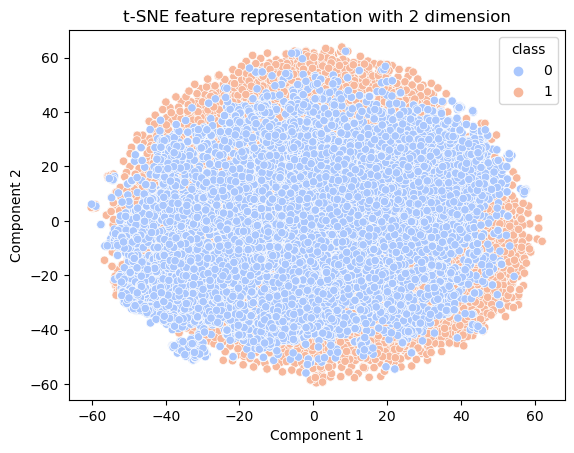

In [10]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, random_state=123)
tsne_x = tsne.fit_transform(X) 

# create dataframe using the generated features
tsne_df = pd.DataFrame(data = tsne_x, columns = ['Com1', 'Com2'])
tsne_df['class'] = y

# Vizualize 
sns.scatterplot(data=tsne_df, x="Com1", y="Com2", hue="class", legend="full",palette="coolwarm")
plt.xlabel('Component 1', fontsize=10)
plt.ylabel('Component 2', fontsize=10)
plt.title("t-SNE feature representation with 2 dimension")

In [11]:
import csv
reader = csv.reader(open('../data/pretrained/dna2vec-20161219-0153-k3to8-100d-10c-29320Mbp-sliding-Xat.csv', 'r')) 
kmers_wv = {}
for row in reader:
    k = row[0]
    kmers_wv[k] = row[1:]
wvs = []
for kmer in X.columns:
    wvs.append(kmers_wv[kmer.upper()])
wvs = np.array(wvs, dtype=float)
wvs.shape

(256, 100)

In [12]:
X.shape

(38931, 256)

In [13]:
print(wvs)

[[ 0.015238  0.178107 -0.091419 ... -0.363131 -0.184487  0.187017]
 [-0.104339  0.224983 -0.034026 ...  0.283516 -0.506882  0.236254]
 [ 0.216324  0.264992 -0.388045 ...  0.013515 -0.020169 -0.068099]
 ...
 [-0.099851  0.223468  0.495296 ... -0.077472 -0.303269 -0.316688]
 [-0.14453   0.378944  0.136247 ... -0.037    -0.106457 -0.372506]
 [-0.06838   0.251549  0.194397 ... -0.075252 -0.266873 -0.528211]]


In [14]:
X_vec = []

for i in range(X.shape[0]):
    m2 = np.stack((X.iloc[i,:],) * wvs.shape[1], axis=1)
    vec_X = np.multiply(m2, wvs)
    X_vec.append(vec_X)

X_vec = np.array(X_vec)

In [15]:
print(X_vec.shape)

(38931, 256, 100)


In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.25, random_state= 2,  stratify=y)

print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))


(array([0, 1]), array([14094, 15104]))
(array([0, 1]), array([4698, 5035]))


In [17]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

2022-12-08 13:07:15.543334: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
inputs = keras.Input(shape= X_train.shape[1:], name="Input Sequence")

x_a = layers.Conv1D(filters = 120, kernel_size = 1, activation='relu')(inputs)
x_b = layers.Conv1D(filters = 120, kernel_size = 3, activation='relu')(inputs)
x_c = layers.Conv1D(filters = 120, kernel_size = 5, activation='relu')(inputs)
x_d = layers.Conv1D(filters = 120, kernel_size = 9, activation='relu')(inputs)
#x_e = layers.Conv1D(filters = 120, kernel_size = 15, activation='relu')(inputs)
#x_f = layers.Conv1D(filters = 120, kernel_size = 20, activation='relu')(inputs)

x_1 = layers.Concatenate(axis=1)([x_a, x_b, x_c, x_d])

x = layers.Flatten()(x_1)
#x = layers.Dense(512, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs, name="hot_model")

2022-12-08 13:07:22.037018: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [19]:
model.summary()

Model: "hot_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input Sequence (InputLayer)    [(None, 256, 100)]   0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 256, 120)     12120       ['Input Sequence[0][0]']         
                                                                                                  
 conv1d_1 (Conv1D)              (None, 254, 120)     36120       ['Input Sequence[0][0]']         
                                                                                                  
 conv1d_2 (Conv1D)              (None, 252, 120)     60120       ['Input Sequence[0][0]']         
                                                                                          

In [22]:

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.FalsePositives(),
                       tf.keras.metrics.FalseNegatives()])

checkpoint = keras.callbacks.ModelCheckpoint(filepath='saved_models/worm/my_best_model.epoch{epoch:02d}-acc{val_binary_accuracy:.2f}.hdf5', 
                             monitor='val_binary_accuracy',
                             verbose=1, 
                             save_best_only=True,
                             mode='max')


In [23]:
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=32,
    epochs=50,
    verbose='auto',
    callbacks=[checkpoint],
    validation_split=0.20,
    validation_data=None,
    shuffle=True,
    class_weight=None,
    sample_weight=None,
    initial_epoch=0,
    steps_per_epoch=None,
    validation_steps=None,
    validation_batch_size=None,
    validation_freq=1,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False
)

Epoch 1/50
730/730 [==============================] - ETA: 0s - loss: 0.4306 - binary_accuracy: 0.8078 - false_positives_1: 2570.0000 - false_negatives_1: 1919.0000
Epoch 1: val_binary_accuracy improved from -inf to 0.81747, saving model to saved_models/worm/my_best_model.epoch01-acc0.82.hdf5
730/730 [==============================] - 90s 119ms/step - loss: 0.4306 - binary_accuracy: 0.8078 - false_positives_1: 2570.0000 - false_negatives_1: 1919.0000 - val_loss: 0.4173 - val_binary_accuracy: 0.8175 - val_false_positives_1: 611.0000 - val_false_negatives_1: 455.0000
Epoch 2/50
730/730 [==============================] - ETA: 0s - loss: 0.4114 - binary_accuracy: 0.8164 - false_positives_1: 2601.0000 - false_negatives_1: 1687.0000
Epoch 2: val_binary_accuracy did not improve from 0.81747
730/730 [==============================] - 82s 112ms/step - loss: 0.4114 - binary_accuracy: 0.8164 - false_positives_1: 2601.0000 - false_negatives_1: 1687.0000 - val_loss: 0.4177 - val_binary_accuracy: 0.

305/305 [==============================] - 7s 24ms/step
              precision    recall  f1-score   support

           0       0.86      0.72      0.78      4698
           1       0.77      0.89      0.83      5035

    accuracy                           0.81      9733
   macro avg       0.82      0.80      0.80      9733
weighted avg       0.81      0.81      0.81      9733



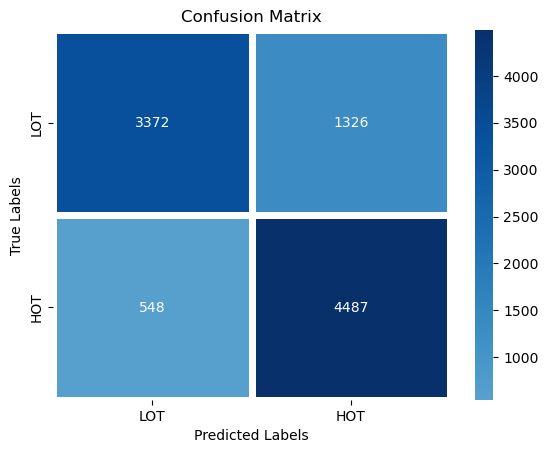

In [24]:
prob = model.predict(X_test)
y_pred = np.array([1 if p>0.5 else 0 for p in prob])
y_test, y_pred

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
print(classification_report(y_test, y_pred))
cf = confusion_matrix(y_test, y_pred)
ax = plt.subplot()
sns.heatmap(cf, annot=True, fmt='d', ax=ax, linewidths=5, cmap="Blues", center=0)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['LOT', 'HOT'])
ax.yaxis.set_ticklabels(['LOT', 'HOT'])
plt.show()

In [27]:
list(history.history.keys())

['loss',
 'binary_accuracy',
 'false_positives_1',
 'false_negatives_1',
 'val_loss',
 'val_binary_accuracy',
 'val_false_positives_1',
 'val_false_negatives_1']

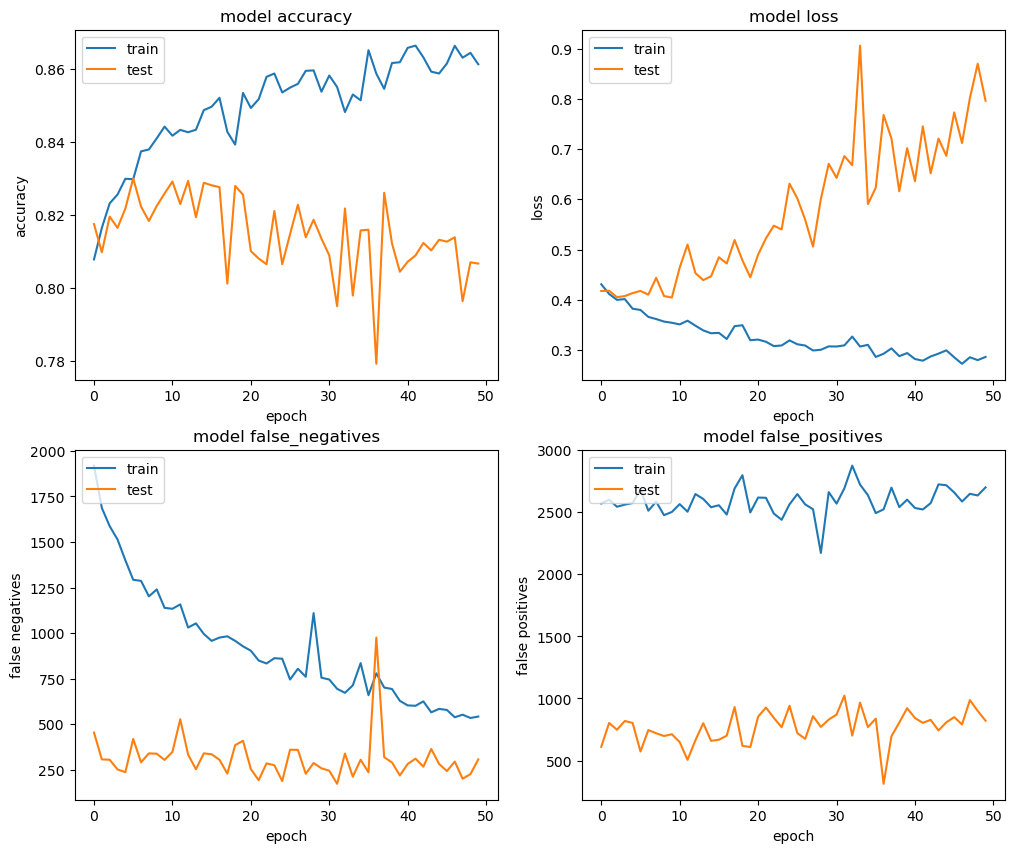

In [28]:
metrics = list(history.history.keys())
fig = plt.figure(figsize=(12,10))
# summarize history for accuracy
plt.subplot(2,2,1)
plt.plot(history.history[metrics[1]])
plt.plot(history.history[metrics[5]])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
#plt.show()
# summarize history for loss
plt.subplot(2,2,2)
plt.plot(history.history[metrics[0]])
plt.plot(history.history[metrics[4]])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
#plt.show()
# summarize history for false_negatives
plt.subplot(2,2,3)
plt.plot(history.history[metrics[3]])
plt.plot(history.history[metrics[7]])
plt.title('model false_negatives')
plt.ylabel('false negatives')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
#plt.show()

# summarize history for false_positives
plt.subplot(2,2,4)
plt.plot(history.history[metrics[2]])
plt.plot(history.history[metrics[6]])
plt.title('model false_positives')
plt.ylabel('false positives')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()